# Decision Tree Classification

## Part 1: Creating a Decision Tree Classifier

In this part of the lab, you will create a decision tree classifier that will learn from a labelled dataset.

The dataset contains the names and demographic details for each passenger. In addition, details of the passengers' trip are included. From this data, we can be build a decision tree that illustrates the factors that contributed to survivability, or lack of it, for the voyage.

The datasets contain the following variables:

| Variable       | Description                                                                  |
|----------------|------------------------------------------------------------------------------|
| 1. PassengerID | Unique identifier for each passenger                                         |
| 2. Survival    | Did the passenger survive? (0 = No; 1 = Yes)                                 |
| 3. Pclass      | Passenger ticket class. (1 = 1st; 2 = 2nd; 3 = 3rd)                          |
| 4. Name        | Name of the passenger. (last name, first name)                               |
| 5. Gender      | Male or female                                                               |
| 6. Age         | Age in years. Mostly integers with float values for children under one year. |
| 7. SibSp       | Number of siblings or spouse onboard.                                        |
| 8. Parch       | Number of parents or children onboard.                                       |
| 9. Ticket      | Ticket number                                                                |
| 10. Fare       | Amount paid for fare in pre-1970 British Pounds                              |
| 11. Cabin      | Cabin number                                                                 |
| 12. Embarked   | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)         |

We can ask about the factors that contributed to passengers surviving or perishing in the Titanic disaster, for example, is there a connection between a gender of the passenger and the chance of surviving, or what is the most common age of the survivors

### Step 1: Creating the dataframe

**Importing pandas and the csv file**

In [1]:
import pandas as pd

#create a pandas dataframe called "training" from the titanic-train.csv file
training = pd.read_csv("./Data/titanic-train.csv")

Verifing the import and taking a look at the data

In [2]:
training.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  915 non-null    int64  
 1   Survived     915 non-null    int64  
 2   Pclass       915 non-null    int64  
 3   Name         915 non-null    object 
 4   Gender       915 non-null    object 
 5   Age          738 non-null    float64
 6   SibSp        915 non-null    int64  
 7   Parch        915 non-null    int64  
 8   Ticket       915 non-null    object 
 9   Fare         915 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     914 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 85.9+ KB


There are some missing age, cabin and embarked values in the data set

In [3]:
training.head()

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S
1,2,0,3,"Asim, Mr. Adola",male,35.0,0,0,SOTON/O.Q. 3101310,7.0500,NaN,S
2,3,0,3,"Nankoff, Mr. Minko",male,NaN,0,0,349218,7.8958,NaN,S
3,4,0,1,"Thayer, Mr. John Borland",male,49.0,1,1,17421,110.8833,C68,C
4,5,0,3,"Strandberg, Miss. Ida Sofia",female,22.0,0,0,7553,9.8375,NaN,S


### Step 2: Preparing the Data for the Decision Tree Model

**Replacing string data with numeric labels**

We will use scikit-learn to create the decision trees. The decision tree model we will be using can only handle numeric data. The values for the Gender variable must be transformed into numeric representations. 0 will be used to represent "male" and 1 will represent "female."

In [4]:
training["Gender"] = training["Gender"].apply(lambda toLabel: 0 if toLabel == 'male' else 1)

**Verifying that the Gender variable has been changed**

In [5]:
training.head()

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,1,"Davidson, Mr. Thornton",0,31.0,1,0,F.C. 12750,52.0000,B71,S
1,2,0,3,"Asim, Mr. Adola",0,35.0,0,0,SOTON/O.Q. 3101310,7.0500,NaN,S
2,3,0,3,"Nankoff, Mr. Minko",0,NaN,0,0,349218,7.8958,NaN,S
3,4,0,1,"Thayer, Mr. John Borland",0,49.0,1,1,17421,110.8833,C68,C
4,5,0,3,"Strandberg, Miss. Ida Sofia",1,22.0,0,0,7553,9.8375,NaN,S


**Addressing Missing Values in the Dataset**

The output of the info() method above indicated that about 180 observations are missing the age value. The age value is important to our analysis. We must address these missing values in some way. While not ideal, we can replace these missing age values with the mean of the ages for the entire dataset.

In [6]:
training["Age"].fillna(training["Age"].mean(), inplace=True)

**Verifing that the values have been replaced**

In [7]:
training["Age"].isnull().any()

False

In [8]:
training.head()

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,1,"Davidson, Mr. Thornton",0,31.000000,1,0,F.C. 12750,52.0000,B71,S
1,2,0,3,"Asim, Mr. Adola",0,35.000000,0,0,SOTON/O.Q. 3101310,7.0500,NaN,S
2,3,0,3,"Nankoff, Mr. Minko",0,29.970867,0,0,349218,7.8958,NaN,S
3,4,0,1,"Thayer, Mr. John Borland",0,49.000000,1,1,17421,110.8833,C68,C
4,5,0,3,"Strandberg, Miss. Ida Sofia",1,22.000000,0,0,7553,9.8375,NaN,S


The value that was used to replace the missing ages is 29.970867

### Step 3: Training and Scoring the Decision Tree Model

**Creating an array object with the variable that will be the target for the model**

In [9]:
#create the array for the target values
y_target = training["Survived"].values

**Creating an array of the values that will be the input for the model**

In [10]:
columns = ["Fare", "Pclass", "Gender", "Age", "SibSp"]
#create the variable to hold the features that the classifier will use
X_input = training[list(columns)].values

**Creating the learned model**

In [11]:
#import the tree module from the sklearn library
from sklearn import tree

#create clf_train as a decision tree classifier object
clf_train = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)

#train the model using the fit() method of the decision tree object. 
#Supply the method with the input variable X_input and the target variable y_target
clf_train = clf_train.fit(X_input, y_target)

**Evaluating the model**

In [12]:
clf_train.score(X_input,y_target)

0.8163934426229508

This score value indicates that classifications made by the model should be correct approximately 82% of the time

### Step 6: Visualizing the Tree

**Creating the intermediate file output**

In [13]:
from six import StringIO
with open("./Data/titanic.dot", 'w') as f:
  f = tree.export_graphviz(clf_train, out_file=f, feature_names=columns)

**Installing Graphviz**

**Converting the intermediate file to a graphic**

In [14]:
#run the Graphviz dot command to convert the .dot file to .png
!dot -Tpng ./Data/titanic.dot -o ./Data/titanic.png

**Displaying the image**

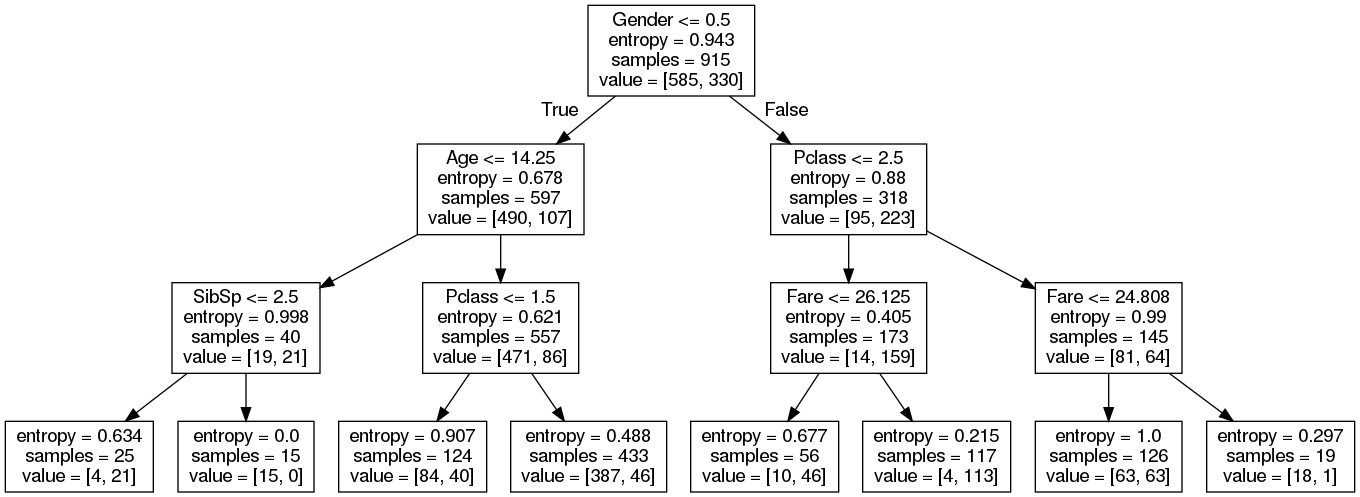

In [15]:
#import the Image module from the Ipython.display libary
from IPython.display import Image

#display the decison tree graphic
Image("./Data/titanic.png")

**Interpreting the tree**

From the tree, we can see several things. First, at the root of the tree is the Gender variable, indicating that it is the single most important factor in making the classification. The branches to the left are for Gender = 0 or male. Each root and intermediate node contains the decision factor, the entropy, and the number of passengers who fit the critierion at that point in the tree. For example, the root node indicates that there are 915 observations that make up the learning data set. At the next level, we can see that 597 people were male, and 318 were female. In the third level, at the far right, we can see that 145 people were female and had a ticket of the first or second class. Finally, the leaf nodes for that intermediate node indicate that 19 of these passengers paid a fare of more than 24.808.

Finally, the elements in the value array indicate survival. The first value is the number of people who died, and the second is the number of survivors for each criterion. The root node tells us that out of our sample, 585 people died and 330 survived.

Entropy is a measure of noise in the decision. Noise can be viewed as uncertainty. For example, in nodes in which the decision results in equal values in the survival value array, the entropy is at its highest possible value, which is 1.0. This means that the model was unable to definitively make the classification decision based on the input variables. For values of very low entropy, the decision was much more clear cut, and the difference in the number of survivors and victims is much higher.

We can see that the group where the most people died is group of men over 14 years old in the second or third class. The group that had the most survivors is group of women in the first or second class that paid a fare of more than 26.125.

## Part 2: Applying the Decision Tree Model

### Step 1: Importing and Preparing the Data

**Importing the data**

In [16]:
#import the file into the 'testing' dataframe.
testing = pd.read_csv("./Data/titanic-test.csv")

In [17]:
testing.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  393 non-null    int64  
 1   Survived     393 non-null    int64  
 2   Pclass       393 non-null    int64  
 3   Name         393 non-null    object 
 4   Gender       393 non-null    object 
 5   Age          307 non-null    float64
 6   SibSp        393 non-null    int64  
 7   Parch        393 non-null    int64  
 8   Ticket       393 non-null    object 
 9   Fare         393 non-null    float64
 10  Cabin        93 non-null     object 
 11  Embarked     392 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 37.0+ KB


There are 393 records in the data set. Age variable is missing 86 values

**Using a lambda expression to replace the "male" and "female" values with 0 for male and 1 for female..**

In [18]:
testing["Gender"] = testing["Gender"].apply(lambda toLabel: 0 if toLabel == 'male' else 1)

**Replacing the missing age values with the mean of the ages**

In [19]:
#Use the fillna method of the testing dataframe column "Age" 
#to replace missing values with the mean of the age values.
testing["Age"].fillna(testing["Age"].mean(), inplace=True)

**Verifying that the values have been replaced**

In [20]:
testing.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  393 non-null    int64  
 1   Survived     393 non-null    int64  
 2   Pclass       393 non-null    int64  
 3   Name         393 non-null    object 
 4   Gender       393 non-null    int64  
 5   Age          393 non-null    float64
 6   SibSp        393 non-null    int64  
 7   Parch        393 non-null    int64  
 8   Ticket       393 non-null    object 
 9   Fare         393 non-null    float64
 10  Cabin        93 non-null     object 
 11  Embarked     392 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 37.0+ KB


In [21]:
testing.head()

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,916,0,2,"Coleridge, Mr. Reginald Charles",0,29.0,0,0,W./C. 14263,10.50,NaN,S
1,917,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",1,40.0,1,1,16966,134.50,E34,C
2,918,0,3,"Windelov, Mr. Einar",0,21.0,0,0,SOTON/OQ 3101317,7.25,NaN,S
3,919,1,1,"Minahan, Miss. Daisy E",1,33.0,1,0,19928,90.00,C78,Q
4,920,1,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.00,NaN,S


### Step 2: Labeling the testing dataset

**Creating the array of input variables from the testing data set**

In [22]:
#create the variable X_input to hold the features that the classifier will use
X_input = testing[list(columns)].values

**Applying the model to the testing data set**

In [23]:
#apply the model to the testing data and store the result in a pandas dataframe.
#Use X_input as the argurment for the predict() method of the clf_train classifier object

target_labels = clf_train.predict(X_input)

#convert the target array into a pandas dataframe using the pd.DataFrame() method and target as argument
target_labels = pd.DataFrame({'Est_Survival':target_labels, 'Name':testing['Name']})

#display the first few rows of the data set
target_labels.head()

,Est_Survival,Name
0,0,"Coleridge, Mr. Reginald Charles"
1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn..."
2,0,"Windelov, Mr. Einar"
3,1,"Minahan, Miss. Daisy E"
4,0,"Wilkes, Mrs. James (Ellen Needs)"


**Evaluating the accuracy of the estimated labels**

In [24]:
#import the numpy library as np
import numpy as np
# Load data for all passengers in the variable all_data
all_data = pd.read_csv("./Data/titanic_all.csv")
# Merging using the field Name as key, selects only the rows of the two datasets that refer to the same passenger
testing_results = pd.merge(target_labels, all_data[['Name','Survived']], on=['Name'])

# Compute the accuracy as a ratio of matching observations to total osbervations. Store this in in the variable acc.
acc = np.sum(testing_results['Est_Survival'] == testing_results['Survived']) / float(len(testing_results))
# Print the result
print(acc)

0.7588832487309645


## Part 3: Evaluating the Decision Tree Model

The sklearn library includes a module that can be used to evaluate the accurracy of the decision tree model. The train_test_split() method will divide the observations in whole data set into two randomly selected arrays of observations that makeup the testing and training datasets. After fitting the model to the training data, the trained model can be scored and the prediction accurracy compared for both the training and test datasets. It is desirable for the two scores to be close, but the accuracy for the test dataset is normally lower that for the training data set.

**Step 1: Importing the data**

In [25]:
#import the titanic_all.csv file into a dataframe called all_data. Specify the list of columns to import.
all_data = pd.read_csv("./Data/titanic_all.csv", usecols=['Survived','Pclass','Gender','Age','SibSp','Fare'])
#View info for the new dataframe
all_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1308 non-null   int64  
 1   Pclass    1308 non-null   int64  
 2   Gender    1308 non-null   object 
 3   Age       1045 non-null   float64
 4   SibSp     1308 non-null   int64  
 5   Fare      1308 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 61.4+ KB


There are 1308 records in the data set. Age variable is missing 236 values

### Step 2: Preparing the data

**Removing the "male" and "female" strings and replace them with 0 and 1 respectively**

In [26]:
all_data["Gender"] = all_data["Gender"].apply(lambda toLabel: 0 if toLabel == 'male' else 1)

**Replacing the missing age values with the mean of the age of all members of the data set**

In [27]:
all_data["Age"].fillna(all_data["Age"].mean(), inplace=True)
all_data.head()

,Survived,Pclass,Gender,Age,SibSp,Fare
0,1,1,1,29.0000,0,211.3375
1,1,1,0,0.9167,1,151.5500
2,0,1,1,2.0000,1,151.5500
3,0,1,0,30.0000,1,151.5500
4,0,1,1,25.0000,1,151.5500


### Step 2: Creating the input and output variables for the training and testing data

**Designating the input variables and output variables and generating the arrays**

In [28]:
#Import train_test_split() from the sklearn.model_selection libary 
from sklearn.model_selection import train_test_split

#create the input and target variables as uppercase X and lowercase y. Reuse the columns variable.
X = all_data[list(columns)].values
y = all_data["Survived"].values

#generate the four testing and training data arrays with the train_test_split() method
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.40, random_state=0)

**Training the model and fitting it to the testing data**

In [29]:
#create the training decision tree object
clf_train = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)

#fit the training model using the input and target variables
clf_train = clf_train.fit(X_train, y_train)

**Comparing models by scoring each**

In [30]:
#score the model on the two datasets and store the scores in variables. Convert the scores to strings using str()
train_score = str(clf_train.score(X_train,y_train))
test_score = str(clf_train.score(X_test,y_test))

#output the values in a test string
print('Training score = '+ train_score+' Testing score = '+test_score)

Training score = 0.8201530612244898 Testing score = 0.8053435114503816


We have now compared the scores for the trained model on both test and validation data. As expected, the test accuracy score is close, but lower than the score for the training data. This is because normally, the model tends to overfit the training data, therefore the test score is a better evaluation of how the model is able to generalize outside of the training data.

<p style="text-align: center;"><b>Conclusion</b></p>

In this laboratory work we have used a decision tree classifier model to determine who survived the Titanic cruise ship disaster with a data set which contains the details about the more than 1300 hundred passengers who were onboard. There has been created a Decision Tree Classifier that learns from a labelled dataset, applied and evaluated the accurracy of the Decison Tree Model.
The result of the work is the visualization of the decision tree, estimation of the survival of each passenger and comparison between the testing and training models.